# Machine Learning Explainability

![title](http://oi65.tinypic.com/2nvf248.jpg)

We often need to know why a Machine Learning algorithm makes a certain decision. This can be useful in a business or medical context or for regulatory reasons (e.g. EU General Data Protection Regulation).

There are simple and advanced approaches to explainable Machine Learning Algorithms:

On the left is my favorite explaination for a Decision Tree: if Age is <= 41.5 and Number of Products is <= 2.5 there's a "Low Risk" in this case.

On the right is an advanced solution based on SHAP where it shows the impact of each feature.

![title](http://i63.tinypic.com/b7zw42.jpg)

Comment: which tool to use depends on the situation, but in general, I find a simpler approach to create a Decision Tree (left solution). 

A more detailed analysis why SHAP should be superior to a traditional Feature Importance strategy is detailed below in this Jupyter Notebook.

Excellent Resources:

**"Machine Learning Explainability"** by Dan Becker on Kaggle. 
https://www.kaggle.com/learn/machine-learning-explainability

**"Interpretable Machine Learning"** by Christoph Molnar, Ph.D. student at Ludwid-Maximilians Univ. München
https://christophm.github.io/interpretable-ml-book/

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pandas.plotting import scatter_matrix

In [2]:
data = pd.read_excel("Churn.xlsx")
data = data[['RowNumber','CustomerId', 'Surname', 'CreditScore','Geography',
             'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
             'IsActiveMember', 'EstimatedSalary', 'Exited']]

In [3]:
data.groupby('Exited')['RowNumber'].count()

Exited
0    7963
1    2037
Name: RowNumber, dtype: int64

In [4]:
data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [5]:
data.shape

(10000, 14)

# Nominal Feature Encoding (geography + gender)

In [9]:
Geography_columns = data['Geography'].unique().tolist()
Gender_columns = data['Gender'].unique().tolist()
np.save('gender', Gender_columns)
np.save('geography', Geography_columns)

In [10]:
df_train = pd.DataFrame({"Geography":data['Geography'].astype('category',categories=Geography_columns),"Gender":data['Gender'].astype('category',categories=Gender_columns)})
X = pd.get_dummies(df_train)

/Users/francoarda/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


In [11]:
X.head()

Geography_France  Geography_Spain  Geography_Germany  Gender_Female  \
0                 1                0                  0              1   
1                 0                1                  0              1   
2                 1                0                  0              1   
3                 1                0                  0              1   
4                 0                1                  0              1   

   Gender_Male  
0            0  
1            0  
2            0  
3            0  
4            0

In [12]:
data.drop(['Geography', 'Gender', 'Surname'], axis=1, inplace=True)
data.head()

RowNumber  CustomerId  CreditScore  Age  Tenure    Balance  NumOfProducts  \
0          1    15634602          619   42       2       0.00              1   
1          2    15647311          608   41       1   83807.86              1   
2          3    15619304          502   42       8  159660.80              3   
3          4    15701354          699   39       1       0.00              2   
4          5    15737888          850   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

# STANDARDIZE DATA (all non categorical features standardizing with mean of 0 and standard deviation 1)

In [55]:
from sklearn.preprocessing import StandardScaler
numerical = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
             'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(data[numerical])
data[numerical] = scaler.transform(data[numerical])
np.save('numerical', numerical)

In [54]:
data.head()

RowNumber  CustomerId  CreditScore    Age  Tenure  Balance  NumOfProducts  HasCrCard  \
0          1    15634602       -0.326  0.294  -1.042   -1.226         -0.912      0.646   
1          2    15647311       -0.440  0.198  -1.388    0.117         -0.912     -1.548   
2          3    15619304       -1.537  0.294   1.033    1.333          2.527      0.646   
3          4    15701354        0.502  0.007  -1.388   -1.226          0.808     -1.548   
4          5    15737888        2.064  0.389  -1.042    0.786         -0.912      0.646   

   IsActiveMember  EstimatedSalary  Exited  
0           0.970            0.022       1  
1           0.970            0.217       0  
2          -1.031            0.241       1  
3          -1.031           -0.109       0  
4           0.970           -0.365       0

# CONCATENATE + TURN INTO NUMPY ARRAY

In [15]:
# Concatenate + Turn the Dataframe into a NumPy array
X3 = pd.concat([X,data], axis=1)

In [16]:
X3.drop(['RowNumber', 'CustomerId', 'Exited'], axis=1, inplace=True)

In [17]:
X3.head()

Geography_France  Geography_Spain  Geography_Germany  Gender_Female  \
0                 1                0                  0              1   
1                 0                1                  0              1   
2                 1                0                  0              1   
3                 1                0                  0              1   
4                 0                1                  0              1   

   Gender_Male  CreditScore       Age    Tenure   Balance  NumOfProducts  \
0            0    -0.326221  0.293517 -1.041760 -1.225848      -0.911583   
1            0    -0.440036  0.198164 -1.387538  0.117350      -0.911583   
2            0    -1.536794  0.293517  1.032908  1.333053       2.527057   
3            0     0.501521  0.007457 -1.387538 -1.225848       0.807737   
4            0     2.063884  0.388871 -1.041760  0.785728      -0.911583   

   HasCrCard  IsActiveMember  EstimatedSalary  
0   0.646092        0.970243         0.021886  
1  -1.547768        0.970243         0.216534  
2   0.646092       -1.030670         0.240687  
3  -1.547768       -1.030670        -0.108918  
4   0.646092        0.970243        -0.365276

In [18]:
#X2 = array[:,1:13] # ignore RowNumber
Y = data['Exited']

# Train / Test Split

In [25]:
validation_size = 0.2
seed = 12
X_train, X_test, Y_train, Y_test = train_test_split(X3, Y, test_size=validation_size, random_state=seed)

In [26]:
X3.columns.values

array(['Geography_France', 'Geography_Spain', 'Geography_Germany',
       'Gender_Female', 'Gender_Male', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'], dtype=object)

In [27]:
#dir(X3.columns)

# Class Imbalance

In [28]:
# Calculate class imbalance
data['Exited'].value_counts(lambda column: column.sum()/(column != 0).sum())

0    0.796
1    0.204
Name: Exited, dtype: float64

# Training XGBoost Model

In [29]:
# fit the model to the training data
model = XGBClassifier(base_score=0.5,
                      booster='gbtree',
                      colsample_bylevel=1,
                      colsample_bytree=1, 
                      gamma=0, 
                      learning_rate=0.1, 
                      max_delta_step=0, 
                      max_depth=3, 
                      min_child_weight=1, 
                      missing=None, 
                      n_estimators=40,
                      n_jobs=1, 
                      nthread=None, 
                      objective='binary:logistic', 
                      random_state=0,
                      reg_alpha=0, 
                      reg_lambda=1, 
                      scale_pos_weight=1, 
                      seed=None,
                      silent=True, 
                      subsample=1)

model.fit(X_train, Y_train, eval_metric=None, eval_set=[(X_train, Y_train)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [31]:
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.15%


In [50]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]
model.fit(X_train, Y_train, eval_metric="error", eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [51]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

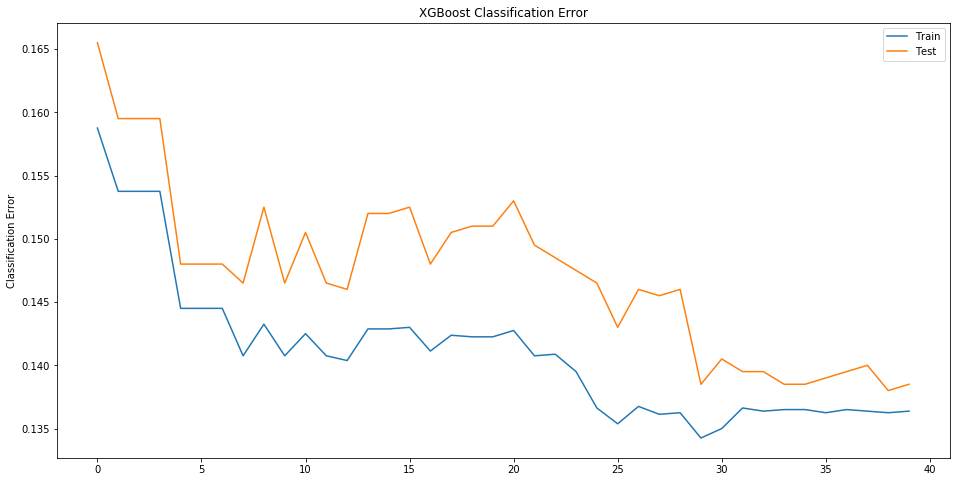

In [52]:
# plot classification error
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (16,8)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

From reviewing the Classification Error, it looks like there is an opportunity to stop the learning early, perhaps somewhere around epoch 40.

# Confusion Matrix
The confusion matrix is a handy presentation of the accuracy of a model with two or more classes. The table presents predictions on the x-axis and accuracy outcomes on the y-axis. The cells of the table are the number of predictions made by a machine learning algorithm. For example, a machine learning algorithm can predict 0 or 1 and each prediction may actually have been a 0 or 1. Predictions for 0 that were actually 0 appear in the cell for prediction = 0 and
actual = 0, whereas predictions for 0 that were actually 1 appear in the cell for prediction = 0 and actual = 1. And so on.

In [37]:
from sklearn.metrics import classification_report
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1564
           1       0.85      0.44      0.58       436

   micro avg       0.86      0.86      0.86      2000
   macro avg       0.86      0.71      0.75      2000
weighted avg       0.86      0.86      0.84      2000



# K-fold Cross-Validation
The choice of k must allow the size of each test partition to be large enough to be a reasonable sample of the problem, whilst allowing enough repetitions of the train-test evaluation of the algorithm to provide a fair estimate of the algorithms performance on unseen data. In the example below we use 10-fold cross-validation:

In [38]:
num_folds = 10
seed = 12
kfold = KFold(n_splits=num_folds, random_state=seed)
results = cross_val_score(model, X_test, Y_test, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 85.900% (2.508%)


# Area Under ROC Curve
Area under ROC Curve (or AUC for short) is a performance metric for binary classification problems. The AUC represents a model's ability to discriminate between positive and negative classes. An area of 1.0 represents a model that made all predictions perfectly. An area of 0.5 represents a model that is as good as random. ROC can be broken down into sensitivity and specificity. A binary classification problem is really a trade-off between sensitivity and specificity.

- Sensitivity is the true positive rate also called the recall. It is the number of instances from the positive (first) class that actually predicted correctly.

- Specificity is also called the true negative rate. Is the number of instances from the negative (second) class that were actually predicted correctly.

The example below provides a demonstration of calculating AUC.

In [39]:
scoring = 'roc_auc'
results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.630 (0.023)


# The Problem with Classic Feature Attribution

Machine Learning algorithms such as Random Forest or XGBoost are often used for feature selection. The reason is that tree-based strategies naturally rank how well they improvethe puritiy of a node. In strong predicting features the impurity over all trees descreases (a.k.a. gini impurity).

The problem with classic feature attribution is consistency: depending on which feature attribution we look at, we get different answers (see 3 feature importance graphs below).

### Feature importance based on cover:

With 'cover', we get Gender_Female as the most important feature.

The cover metrics referts to the relative number of observations related to this feature. For example, if we have 100 observations, 4 features and 3 trees and feature 1 is used to determine the leaf node for 10,5 and 2 observations in tree 1, tree 2 and tree 3 respectively, then the metric will count cover for this feature as 10+5+2 = 17 observations. This will be calculated for all the 4 features and the cover will be 17 expressed as the percentage for all features.

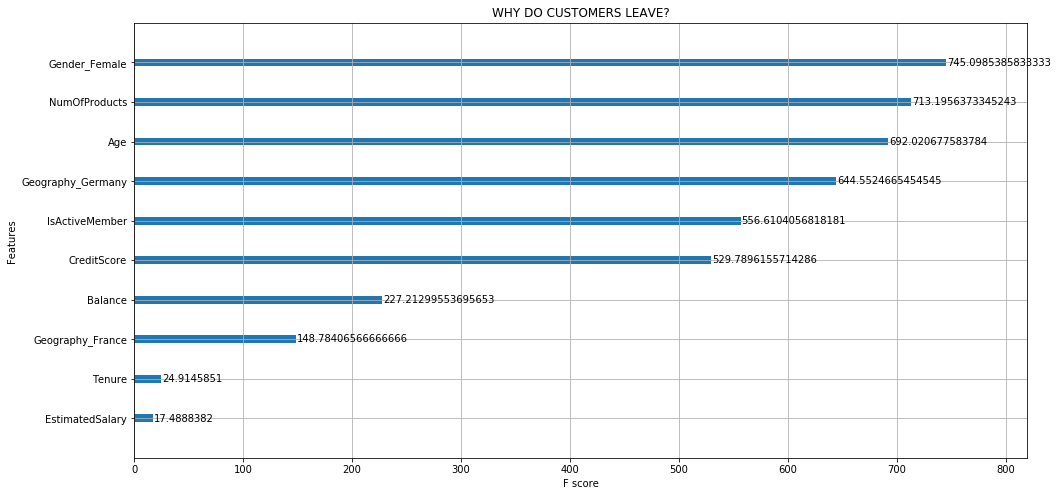

In [43]:
xgboost.plot_importance(model, importance_type="cover")
plt.title('WHY DO CUSTOMERS LEAVE?')
plt.show()

### What makes a good or bad feature importance?
According to the researchers Scott M. Lundberg, Gabriel G. Erio and Su-In Lee from the University of Washington (research paper "Consistent Individualized Feature Attribution for Tree Ensembels" from 18 June 2018), the following two feature attributes are important:

1 - Consistency

2 - Accuracy

Whenever we change a model that relies more on feature, then the attributed importance for that feature should not decrease. Equally, the sum of all the feature importances should sum up to the total importance of the model.

The team created their own library called SHAP (SHapley Additive exPlanations) which uses recent applications in Game Theory to get a CONSISTENT FEATURE ATTRIBUTION.

### Key Churn Predictors based on SHAP
The explanation of features below each contributing to push the model output from the base value to the model output. Features pushing the prediction higher are shown in red. Those features pushing the prediction lower are in blue.
http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions

In [44]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X3)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X3.iloc[0,:])

If we rotate the explanations above by 90 degrees and stack them horizontally, we get the explanation for the entire dataset:

In [45]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X3)

/Users/francoarda/anaconda3/envs/py36/lib/python3.6/site-packages/shap/plots/force.py:98: UserWarning: shap.force_plot is slow many thousands of rows, try subsampling your data.
  warnings.warn("shap.force_plot is slow many thousands of rows, try subsampling your data.")


Visualizing the effects of a single feature to the output of the model:

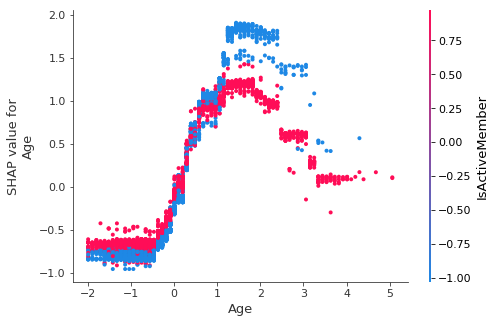

In [46]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Age", shap_values, X3)

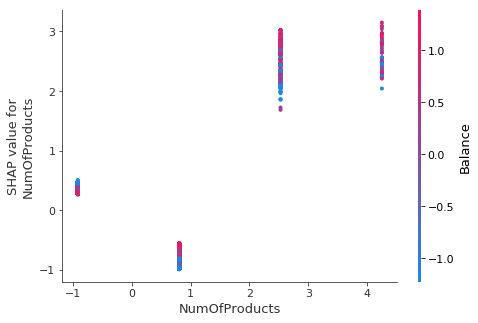

In [47]:
shap.dependence_plot("NumOfProducts", shap_values, X3)

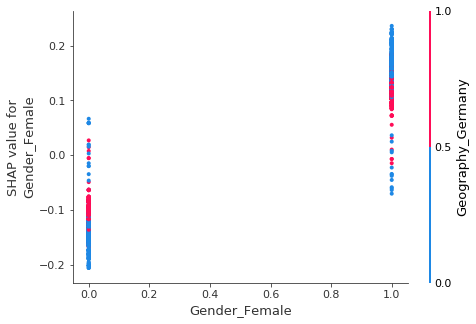

In [48]:
shap.dependence_plot("Gender_Female", shap_values, X3)

The plot below sorts the features by the sum of the value magnitudes:

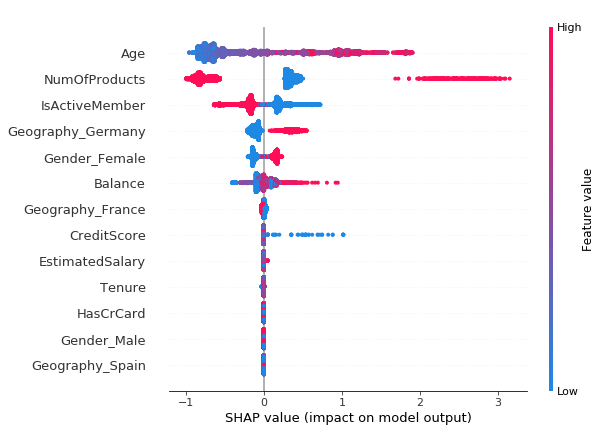

In [49]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X3)